<a href="https://colab.research.google.com/github/ehsanbarkhordar/Bank-Customer-Clustering-By-Transactions/blob/main/Czech_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [2]:
!pip install scikit-learn-extra
!pip install kneed

     |████████████████████████████████| 624kB 18.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp37-cp37m-linux_x86_64.whl size=339947 sha256=d95cff5b5823314d88ac00c25652f6d886c7c493de4a34fda46a007c81ff9655
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [73]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras.layers import Dense, LSTM, GRU, dot, Input, Embedding, \
 TimeDistributed, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import SGD
from tensorflow import feature_column, keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from sklearn_extra.cluster import KMedoids
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import davies_bouldin_score 
from kneed import KneeLocator
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import datetime

In [4]:
my_drive_path = '/content/gdrive/MyDrive/'
dataset_path = my_drive_path + '/lpetrocelli-retail-banking-demo-data/'
onlyfiles = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
onlyfiles

['CRM Call Center Logs.csv',
 'CRM Events.csv',
 'completedcard.csv',
 'LuxuryLoanPortfolio.csv',
 'completedorder.csv',
 'completedloan.csv',
 'completedclient.csv',
 'completedacct.csv',
 'completedtrans.csv',
 'completeddistrict.csv',
 'CRM Reviews.csv',
 'completeddisposition.csv']

In [5]:
# Import Clients
df_clients = pd.read_csv(dataset_path+'completedclient.csv', index_col=[0], low_memory=False)
# Import Transactions
df_trans = pd.read_csv(dataset_path+'completedtrans.csv', index_col=[0], low_memory=False)
# Import Positions
df_positions = pd.read_csv(dataset_path+'completeddisposition.csv', index_col=[0], low_memory=False)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
df_clients = df_clients.join(df_positions.set_index('client_id'), on='client_id')

In [7]:
df_clients

,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id,account_id,type
client_id,,,,,,,,,,,,,,,,,,,,
C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18,A00000001,Owner
C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1,A00000002,Owner
C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1,A00000002,User
C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5,A00000003,Owner
C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5,A00000003,User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1,A00011349,Owner
C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1,A00011349,User
C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61,A00011359,Owner


In [8]:
df_clients[['account_id','sex','age','zipcode']]

,account_id,sex,age,zipcode
client_id,,,,
C00000001,A00000001,Female,29,47246
C00000002,A00000002,Male,54,10040
C00000003,A00000002,Female,59,10162
C00000004,A00000003,Male,43,49047
C00000005,A00000003,Female,39,40852
...,...,...,...,...
C00013955,A00011349,Female,54,10121
C00013956,A00011349,Male,56,10118
C00013968,A00011359,Male,31,2721


In [9]:
zip_set=set(df_clients['zipcode'])
zip_list=list(df_clients['zipcode'])
print("all zip codes in dataset: ",len(zip_list))
print("unique zip codes in dataset: ",len(zip_set))

all zip codes in dataset:  5369
unique zip codes in dataset:  3512


In [10]:
df_clients_onehot = pd.DataFrame()

In [11]:
df_clients_onehot['account_id']=df_clients['account_id']

In [12]:
data=list(df_clients['sex'])
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of sex onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['sex'] = onehot_encoded.tolist()

['Female' 'Male' 'Female' ... 'Male' 'Female' 'Female']
[0 1 0 ... 1 0 0]
shape of sex onehot_encoded:  (5369, 2)


In [13]:
data=list(df_clients['age'])
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of age onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['age'] = onehot_encoded.tolist()

[29 54 59 ... 31 37 46]
[17 42 47 ... 19 25 34]
shape of age onehot_encoded:  (5369, 77)


In [14]:
data=list(df_clients['zipcode'])
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("shape of zipcode onehot_encoded: ",onehot_encoded.shape)
df_clients_onehot['zipcode'] = onehot_encoded.tolist()

[47246 10040 10162 ...  2721 48475 44244]
[2625  167  211 ...  118 3049 1677]
shape of zipcode onehot_encoded:  (5369, 3512)


In [15]:
df_clients_onehot['static_vector'] = df_clients_onehot.apply (lambda row: np.concatenate([row.sex, row.age, row.zipcode]), axis=1)

In [16]:
df_clients_onehot

,account_id,sex,age,zipcode,static_vector
client_id,,,,,
C00000001,A00000001,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000002,A00000002,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000003,A00000002,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000004,A00000003,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00000005,A00000003,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
C00013955,A00011349,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00013956,A00011349,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
C00013968,A00011359,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
print("static vector dimention: ",df_clients_onehot.iloc[0]['static_vector'].shape)

static vector dimention:  (3591,)


In [18]:
# Convert date to python datetime
df_trans['fulldate'] = pd.to_datetime(df_trans['fulldate'],format="%Y-%m-%d")
df_trans['timestamp'] = df_trans.fulldate.values.astype(np.int64) // 10 ** 9

In [19]:
df_trans

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,1356998400
2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,1356998400
3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,1356998400
4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,1356998400
5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,1357084800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056316,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14,1546214400
1056317,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60,1546214400
1056318,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13,1546214400
1056319,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19,1546214400


In [20]:
df_trans = df_trans.sort_values('fulldate')

df_z_scaled = df_trans
df_z_scaled['amount'] = (df_z_scaled['amount'] - df_z_scaled['amount'].mean()) / df_z_scaled['amount'].std()
df_z_scaled['timestamp'] = (df_z_scaled['timestamp'] - df_z_scaled['timestamp'].mean()) / df_z_scaled['timestamp'].std()

df_trans_groupby_account_id = df_z_scaled.groupby(['account_id'])

In [21]:
df_z_scaled

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,-0.548597,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,-2.860870
2,T00171812,A00000576,Credit,Credit in Cash,-0.527595,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,-2.860870
3,T00207264,A00000704,Credit,Credit in Cash,-0.517094,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,-2.860870
4,T01117247,A00003818,Credit,Credit in Cash,-0.559098,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,-2.860870
5,T00579373,A00001972,Credit,Credit in Cash,-0.580101,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,-2.858917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053317,T03629556,A00002990,Credit,NaN,-0.603728,42712.1,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:14:06,2018-12-31T13:14:06,1.417798
1053316,T03630422,A00003025,Credit,NaN,-0.614345,15933.6,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:31:03,2018-12-31T13:31:03,1.417798
1053315,T03631495,A00003053,Credit,NaN,-0.585372,86982.1,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,16:53:60,2018-12-31T16:53:60,1.417798
1053321,T03632209,A00003077,Credit,NaN,-0.593973,68530.7,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:55:47,2018-12-31T14:55:47,1.417798


In [22]:
df = df_trans_groupby_account_id
df_trans_groupby_account_id.size()

account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Length: 4500, dtype: int64

In [23]:
# df.groups.keys()

In [24]:
max_length_of_transaction = df['amount'].count().max()
print("max trans lenght is: ", max_length_of_transaction)
df['amount'].count()

max trans lenght is:  675


account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Name: amount, Length: 4500, dtype: int64

In [25]:
df.get_group('A00000001')

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
149432,T00000001,A00000001,Credit,Credit in Cash,-0.517094,1000.0,NaN,NaN,NaN,2015,3,24,2015-03-24,10:21:45,2015-03-24T10:21:45,-1.274442
157404,T00000005,A00000001,Credit,Collection from Another Bank,-0.235767,4679.0,NaN,JPMorgan Chase,41403269.0,2015,4,13,2015-04-13,08:54:57,2015-04-13T08:54:57,-1.235367
158832,T00000199,A00000001,Credit,Credit in Cash,0.701044,17279.0,NaN,NaN,NaN,2015,4,23,2015-04-23,10:54:46,2015-04-23T10:54:46,-1.215830
162681,T03530438,A00000001,Credit,NaN,-0.620089,17298.2,Interest Credited,NaN,NaN,2015,4,30,2015-04-30,11:01:59,2015-04-30T11:01:59,-1.202154
167083,T00000006,A00000001,Credit,Collection from Another Bank,-0.235767,20977.2,NaN,JPMorgan Chase,41403269.0,2015,5,13,2015-05-13,10:33:00,2015-05-13T10:33:00,-1.176755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032336,T03530481,A00000001,Credit,NaN,-0.615059,16701.5,Interest Credited,NaN,NaN,2018,11,30,2018-11-30,13:58:35,2018-11-30T13:58:35,1.357232
1033713,T00000230,A00000001,Debit,Cash Withdrawal,-0.149552,12186.9,NaN,NaN,NaN,2018,12,3,2018-12-03,13:09:19,2018-12-03T13:09:19,1.363094
1035097,T00000097,A00000001,Debit,Remittance to Another Bank,-0.364616,9734.9,Household,State Street Corp.,87144583.0,2018,12,5,2018-12-05,11:42:20,2018-12-05T11:42:20,1.367001
1045493,T00000049,A00000001,Credit,Collection from Another Bank,-0.235767,13413.9,NaN,JPMorgan Chase,41403269.0,2018,12,13,2018-12-13,14:00:08,2018-12-13T14:00:08,1.382631


In [26]:
sequence_input_list = []
sequence_output_list = []

for k, v in df_trans.groupby('account_id'):
  user_trans_array = pd.concat([v.amount, v.timestamp], axis=1).values
  array = user_trans_array.copy()
  # add start and end to sequence of transations
  add_start_to_array = np.insert(array, 0, [-1, -1], axis=0)
  input_array = np.append(add_start_to_array, [[-2, -2]], axis=0)
  output_array = np.append(array, [[-2, -2]], axis=0)
  # resize array to max_lenght
  input_array.resize((max_length_of_transaction,2), refcheck=False)
  output_array.resize((max_length_of_transaction,2), refcheck=False)
  # append them to list
  sequence_input_list.append(input_array)
  sequence_output_list.append(output_array)

In [27]:
sequence_input_array = np.array(sequence_input_list)
sequence_output_input_array = sequence_input_array
sequence_output_array = np.array(sequence_output_list)
sequence_output_array.shape

(4500, 675, 2)

In [28]:
(sequence_output_input_array == sequence_output_array).all()

False

In [29]:
# Build static input array
list_of_account_ids = list(df.groups.keys())
static_input_list = []
for account_id in list_of_account_ids:
  sub_df = df_clients_onehot.loc[df_clients_onehot['account_id'] == account_id]
  account_static_vector = sub_df.iloc[0]['static_vector']
  static_input_list.append(account_static_vector)
static_input_array = np.array(static_input_list)
print(static_input_array.shape)
static_output_array = static_input_array
static_input_array

(4500, 3591)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [30]:
latent_dim = 256
decoder_dim = 2
###########################################  encoder  ###########################################

# Sequence input shape is N*2 which N is sequence length and 2 is price and time
sequence_input = Input(name='sequence_input', shape=(None, 2))

# Many_to_one_lstm
outputs  = LSTM(2048, return_sequences=True)(sequence_input)
outputs = GRU(1024, return_sequences=True)(outputs)
# outputs = Dropout(0.2, input_shape=(2,))(outputs)
encoder_out , hidden_state, cell_state = LSTM(latent_dim, return_state=True, return_sequences=True)(outputs)

latent_space = Concatenate()([hidden_state, cell_state])
#Layer below output can be used for clustering purposes
latent_space = Dense(latent_dim, activation = 'elu', name='latent_space')(latent_space)

In [31]:
###########################################  decoder  ###########################################

# Temporary input with a time step delay for producing sequence output
# This input is exacly similar to sequence_input with only this diffrence that has a time step delay
sequence_output_input = Input(name='sequence_output_input', shape=(None, 2))

# One to many GRU (because of its simplicity, we used GRU instead of LSTM)
decoder_out = GRU(latent_dim, return_sequences=True)(sequence_output_input,
                                                         initial_state = latent_space)
###########################################  attention  ###########################################
attention = dot([decoder_out, encoder_out], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_out], axes=[2,1])
decoder_combined_context = Concatenate()([context, decoder_out])
###########################################  /attention  ###########################################

decoder_outputs = TimeDistributed(Dense(decoder_dim, activation='sigmoid'),name='decoder_outputs')(decoder_combined_context)

###########################################  /decoder  ###########################################

# Model has three inputs and 2 outputs (last input is temorary)
model = Model(inputs = [sequence_input, sequence_output_input],
              outputs = [decoder_outputs])

model.compile(
    optimizer="adam", loss=["mse", "mse"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 2048)   16801792    sequence_input[0][0]             
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 1024)   9443328     lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  1311744     gru[0][0]                        
______________________________________________________________________________________________

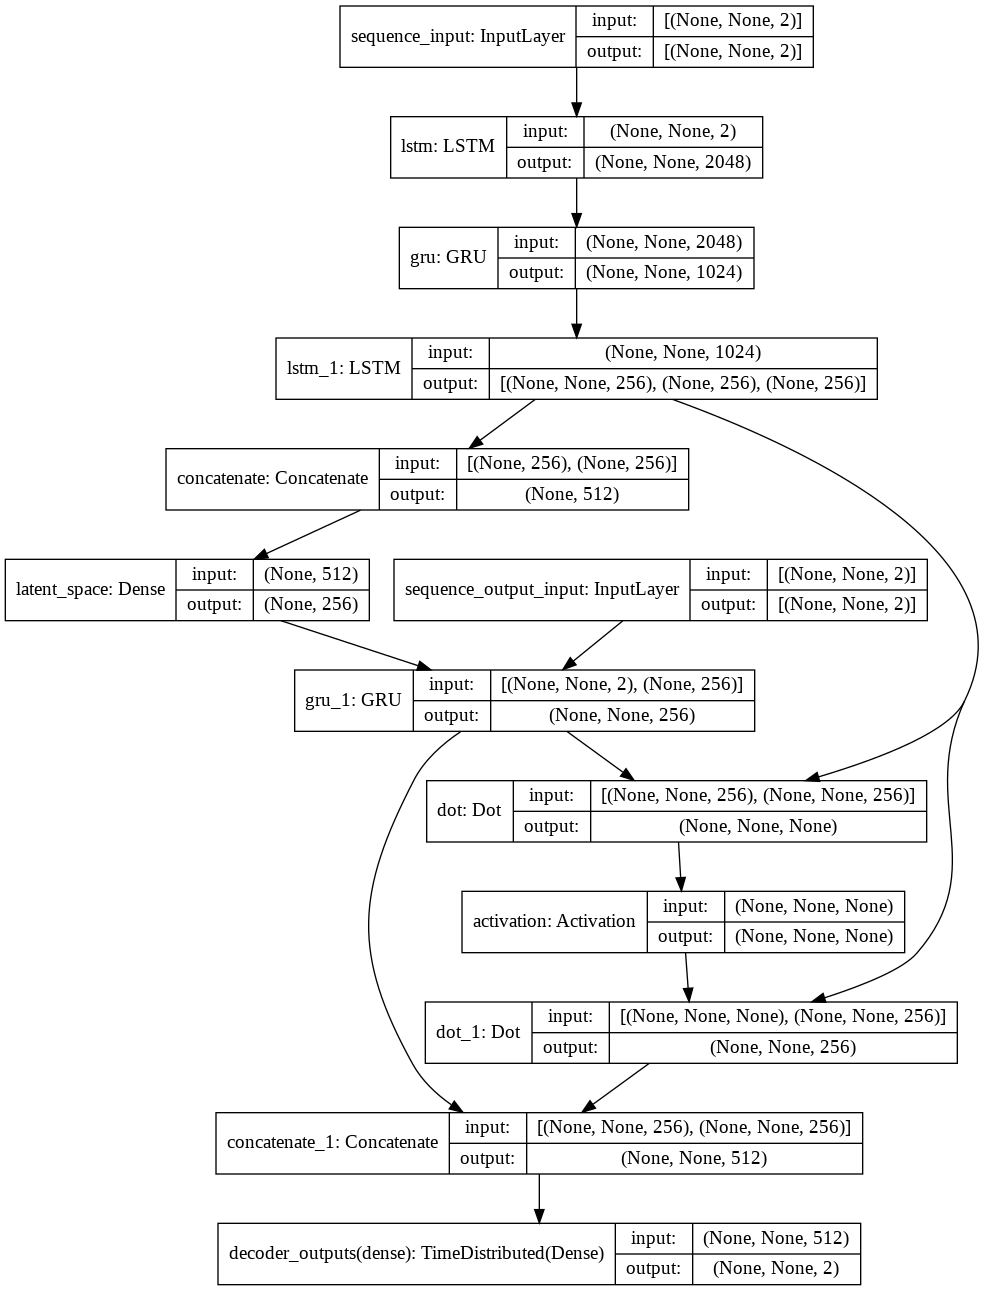

In [32]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(sequence_input_array, sequence_output_array, test_size=0.05, random_state=42)

In [34]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
# fit the keras model on the dataset
batch_size = 128
inputs = [X_train, X_train]
outputs = [y_train]
training_history = model.fit(inputs, outputs, epochs=5,
                             batch_size = batch_size,
                             validation_split=0.1,
                             callbacks=[tensorboard_callback])

Epoch 1/5
31/31 [==============================] - 159s 5s/step - loss: 0.4143 - val_loss: 0.3591
Epoch 2/5
31/31 [==============================] - 142s 5s/step - loss: 0.3453 - val_loss: 0.3591
Epoch 3/5
31/31 [==============================] - 142s 5s/step - loss: 0.3438 - val_loss: 0.3591
Epoch 4/5
31/31 [==============================] - 142s 5s/step - loss: 0.3596 - val_loss: 0.3591
Epoch 5/5
31/31 [==============================] - 142s 5s/step - loss: 0.3564 - val_loss: 0.3591


In [36]:
print("Average test loss: ", np.average(training_history.history['loss']))

Average test loss:  0.3573874056339264


In [71]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [ ]:
# save the model to disk
# model.save(my_drive_path)

In [ ]:
# load model
# model = keras.models.load_model(my_drive_path)

In [72]:
encoder = Model(model.input, model.get_layer("latent_space").output)
# plot_model(encoder, show_shapes=True, show_layer_names=True)

AttributeError: ignored

In [40]:
predictions = encoder.predict(inputs, batch_size = batch_size)

In [41]:
print(predictions.shape)
predictions

(4275, 256)


array([[ -1.      , 229.18744 ,  -1.      , ...,  -1.      ,  -1.      ,
         53.63602 ],
       [ -1.      , 229.18712 ,  -1.      , ...,  -1.      ,  -1.      ,
         53.63599 ],
       [ -1.      , 229.1407  ,  -1.      , ...,  -1.      ,  -1.      ,
         53.606594],
       ...,
       [ -1.      , 229.16179 ,  -1.      , ...,  -1.      ,  -1.      ,
         53.619984],
       [ -1.      , 229.14436 ,  -1.      , ...,  -1.      ,  -1.      ,
         53.61402 ],
       [ -1.      , 229.18724 ,  -1.      , ...,  -1.      ,  -1.      ,
         53.637245]], dtype=float32)

In [42]:
# StandardScaler data before dimention reduction
standard_x = StandardScaler().fit_transform(predictions)
standard_x

array([[ 0.        ,  1.3617857 ,  0.        , ...,  0.        ,
         0.        ,  1.2113941 ],
       [ 0.        ,  1.3489314 ,  0.        , ...,  0.        ,
         0.        ,  1.2095358 ],
       [ 0.        , -0.51310533,  0.        , ...,  0.        ,
         0.        , -0.5803318 ],
       ...,
       [ 0.        ,  0.33282983,  0.        , ...,  0.        ,
         0.        ,  0.23493364],
       [ 0.        , -0.36619908,  0.        , ...,  0.        ,
         0.        , -0.12810338],
       [ 0.        ,  1.3538283 ,  0.        , ...,  0.        ,
         0.        ,  1.2859526 ]], dtype=float32)

In [54]:
# use PCA for dimention reduction because we need to plot result
pca = PCA(n_components=3)
principal_components = pca.fit_transform(standard_x)
X = principal_components
X

array([[-13.63422   ,  -0.7189336 ,   1.1227912 ],
       [-13.541161  ,  -0.31278273,   1.6202056 ],
       [  5.9720407 ,  -1.4668217 ,   0.0276615 ],
       ...,
       [ -2.8725972 ,  -0.56540304,   0.6692144 ],
       [  2.0044718 ,   3.961603  ,  -2.0143352 ],
       [-13.647246  ,   0.4647683 ,   2.7952647 ]], dtype=float32)

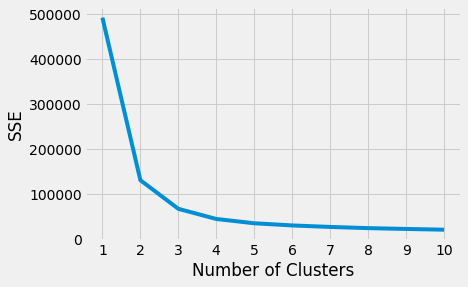

Optimum number of clusters is:  3


In [44]:
kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
}
def elbow_method(X):
  # A list holds the SSE values for each k
  sse = []
  for k in range(1, 11):
      kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
      kmeans.fit(X)
      sse.append(kmeans.inertia_)
  plt.style.use("fivethirtyeight")
  plt.plot(range(1, 11), sse)
  plt.xticks(range(1, 11))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()
  kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
  print("Optimum number of clusters is: ", kl.elbow)
  return kl.elbow
opt_cluster_numbers = elbow_method(X)

In [67]:
def plot_clustering(X, labels, centers):
  # Set up a figure twice as tall as it is wide
  fig = plt.figure(figsize=(30,30))

  # First subplot
  ax = fig.add_subplot(2, 1, 1)

  ax.scatter(X[:, 0], X[:, 1], c=labels)
  ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
  ax.grid(True)
  ax.set_title("2D Plot")

  # Second subplot
  ax = fig.add_subplot(2, 1, 2, projection='3d')
  ax.scatter(X[:,0],X[:,1],X[:,2], c=labels, cmap='viridis',
                edgecolor='k', s=40, alpha = 0.5)
  ax.set_title("3D Plot")
  plt.show()

{0, 1, 2}
[1 1 0 ... 0 0 1]


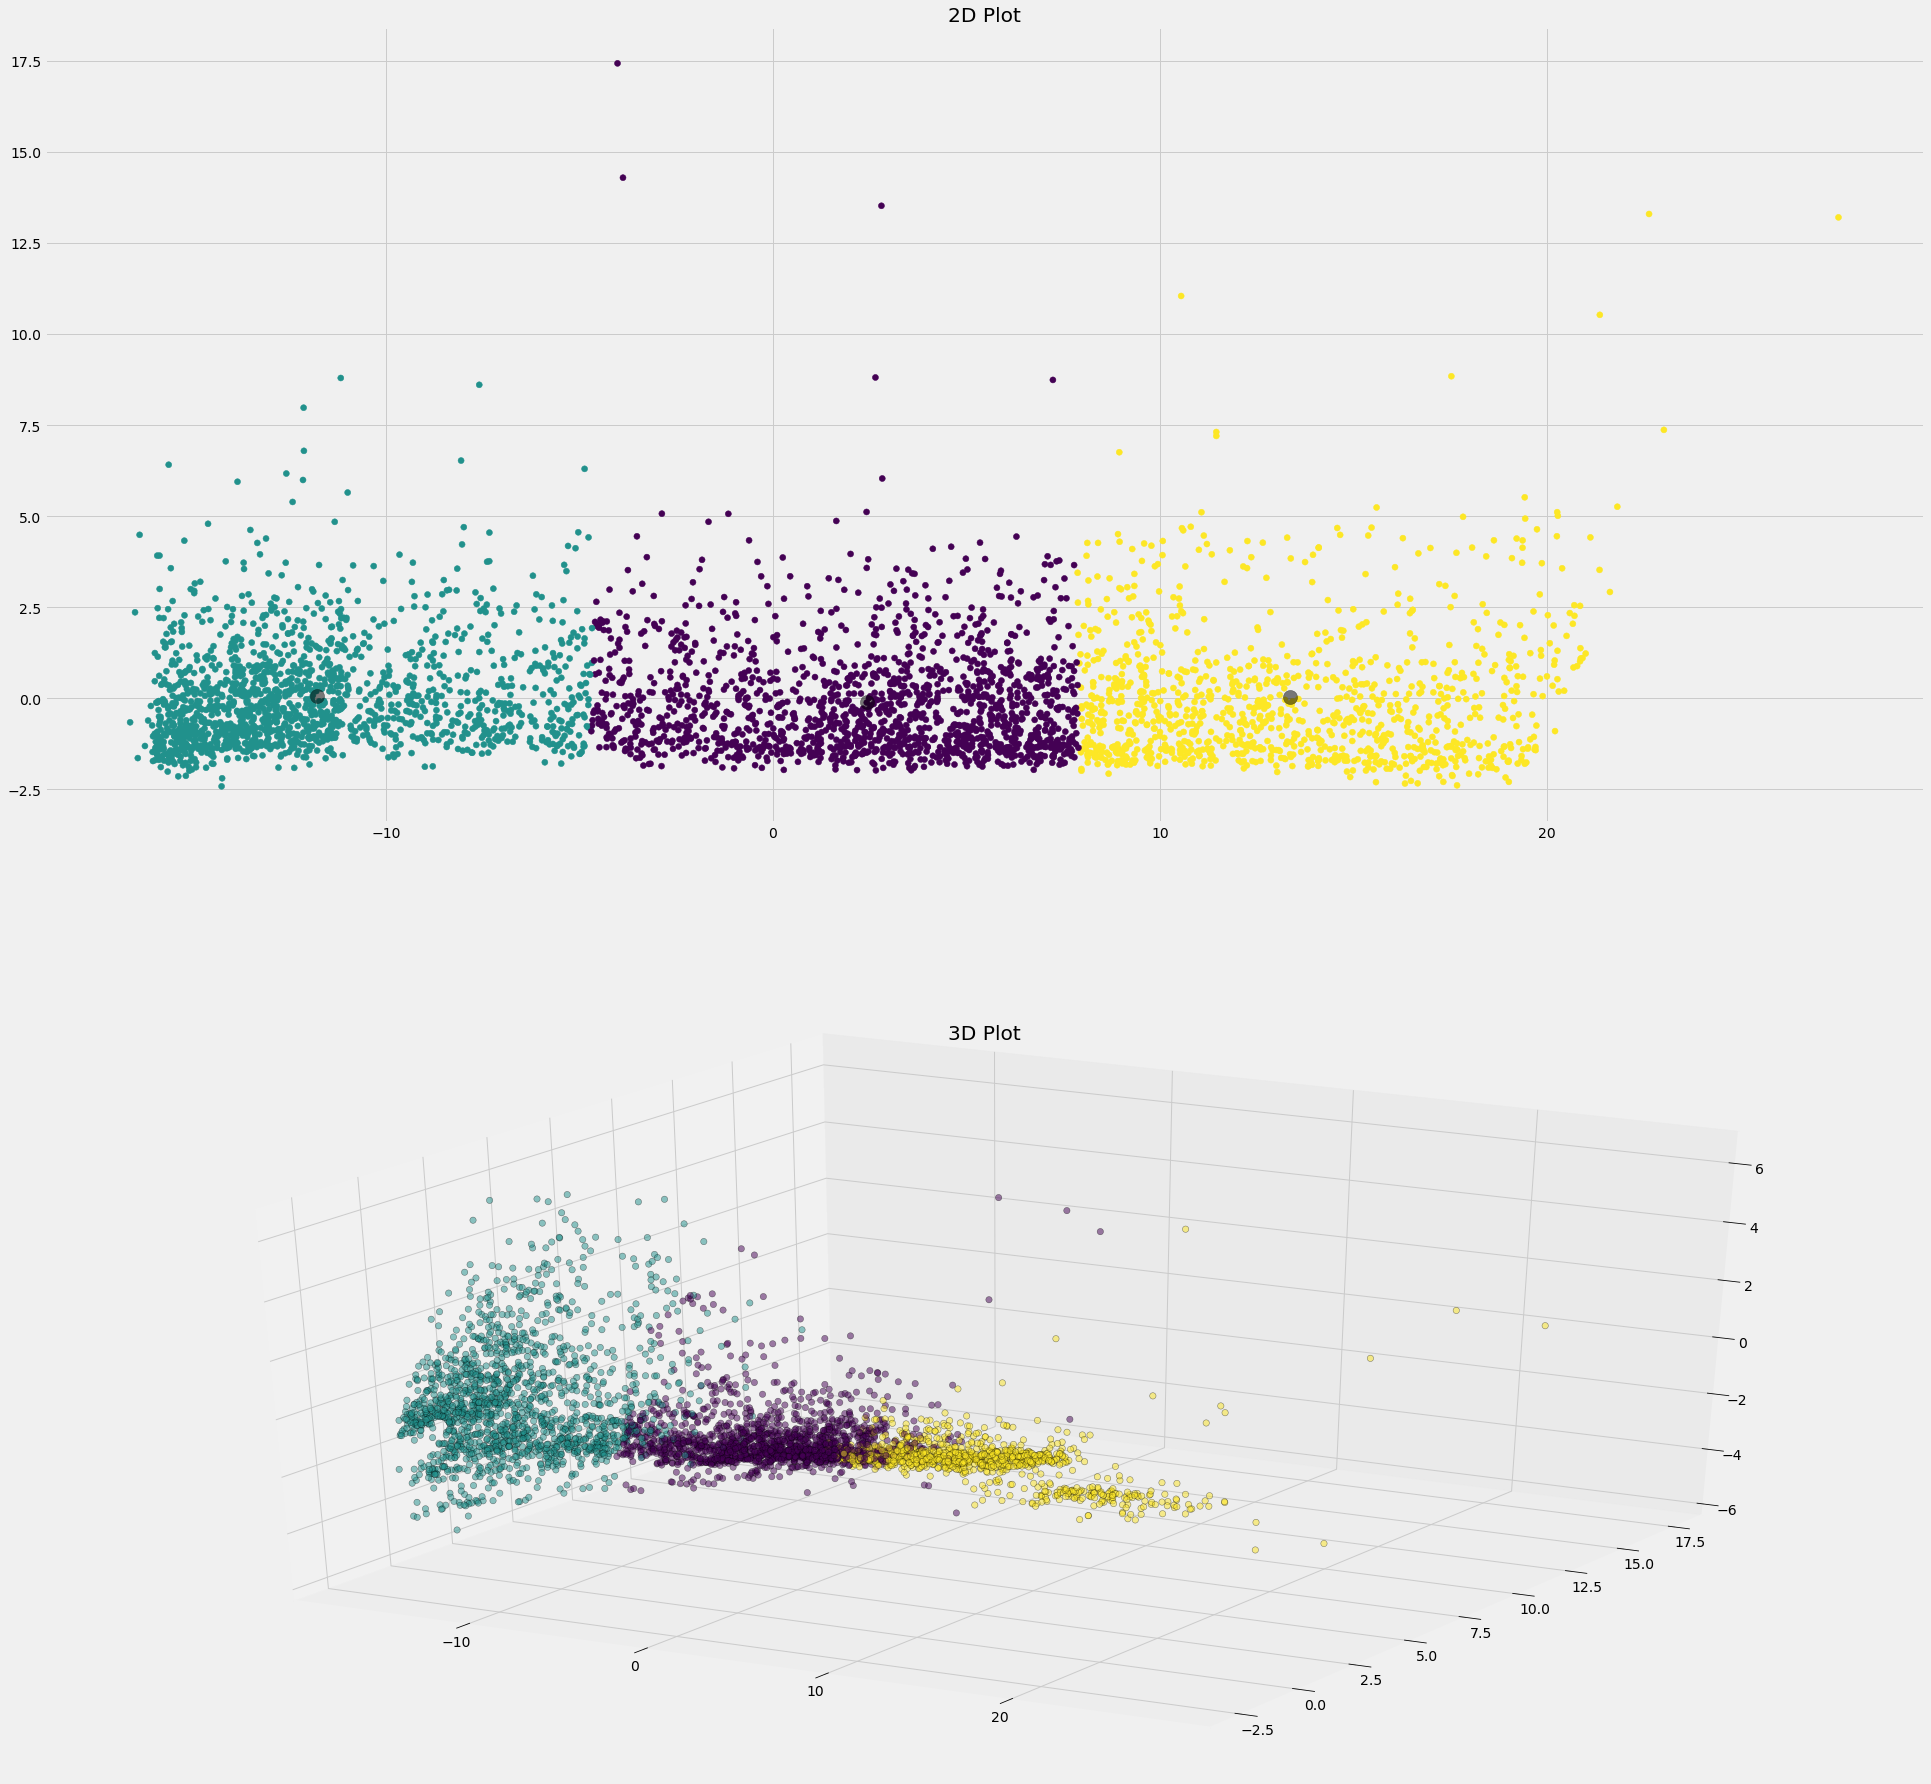

In [46]:
kmeans = KMeans(n_clusters = opt_cluster_numbers, **kmeans_kwargs)
kmeans.fit(X)
print(set(kmeans.labels_))
print(kmeans.labels_)
plot_clustering(X, kmeans.labels_, kmeans.cluster_centers_)

Automatically created module for IPython interactive environment
For n_clusters = 3 The average silhouette_score is : 0.5441233


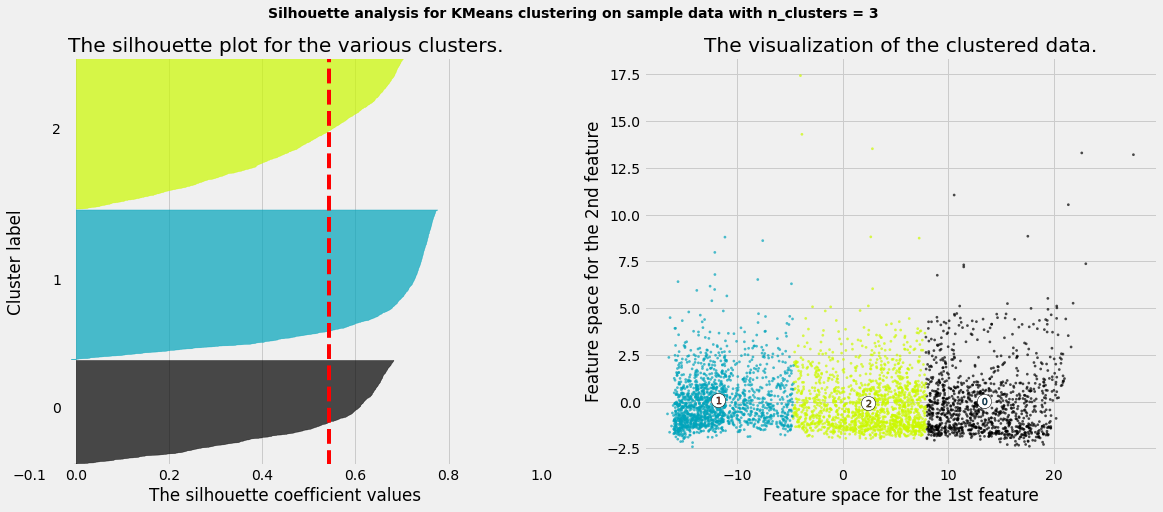

In [56]:
range_n_clusters = [2, 3, 4, 5, 6]
n_clusters = opt_cluster_numbers
# for n_clusters in range_n_clusters:
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
              fontsize=14, fontweight='bold')

plt.show()


In [50]:
DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']


def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster,
     or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c}
     \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements.
     Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid,
      or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of
     Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))

    return min_distance / max_diameter


In [74]:
print("Optimal number of clusters:")

kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
}
kmeans = KMeans(n_clusters = opt_cluster_numbers, **kmeans_kwargs)
kmeans.fit(X)
labels = kmeans.labels_

print("K-means")
print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
distance_matrices = pairwise_distances(X)
dunk = dunn(labels, distance_matrices, diameter_method, cdist_method)
print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)

print("##################################################")

kmedoids = KMedoids(n_clusters = opt_cluster_numbers, random_state=0)
kmedoids.fit(X)
labels = kmedoids.labels_

print("K-medoids")
print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
distance_matrices = pairwise_distances(X)
dunk = dunn(labels, distance_matrices, diameter_method, cdist_method)
print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)


Optimal number of clusters:
K-means
Davies–Bouldin index:  0.6001975785139492
Dunn index:  0.003
Silhouette:  0.5441233
##################################################
K-medoids
Davies–Bouldin index:  0.6039573518653901
Dunn index:  0.0039
Silhouette:  0.5416678


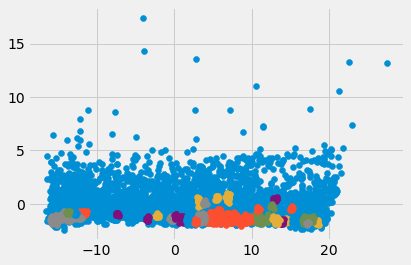

In [81]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# define the model
dbscan_model = DBSCAN(eps=0.30, min_samples=9)
# fit model and predict clusters
dbscan_yhat = dbscan_model.fit_predict(X)
# retrieve unique clusters
clusters = unique(dbscan_yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(dbscan_yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [82]:
labels = dbscan_yhat
print("DBSCAN")
print('eps: ', dbscan_model.eps)
print('min_samples: ', dbscan_model.min_samples)

print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
distance_matrices = pairwise_distances(X)
dunk = dunn(labels, distance_matrices, diameter_method, cdist_method)
print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)

DBSCAN
eps:  0.3
min_samples:  9
Davies–Bouldin index:  1.6270482428567206
Dunn index:  0.001367
Silhouette:  -0.5870976


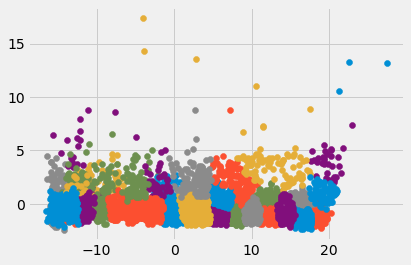

In [76]:
# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot
# define dataset
# define the model

affinity_propagation_model = AffinityPropagation(damping = 0.7)
# fit the model
affinity_propagation_model.fit(X)
# assign a cluster to each example
affinity_yhat = affinity_propagation_model.predict(X)
# retrieve unique clusters
clusters = unique(affinity_yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(affinity_yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [78]:
labels = affinity_yhat
print("AffinityPropagation")
print('damping: ', affinity_propagation_model.damping)
print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
distance_matrices = pairwise_distances(X)
dunk = dunn(labels, distance_matrices, diameter_method, cdist_method)
print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)

AffinityPropagation
damping:  0.7
Davies–Bouldin index:  0.9510069006870328
Dunn index:  0.002318
Silhouette:  0.29339594
